In [1]:
import os
import sys
import cv2
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras.applications.vgg16 import VGG16
from force_utils import DataProcessing, evaluate_model

Using TensorFlow backend.


In [2]:
dataset = DataProcessing('dataset/video.mp4', 'dataset/forceinfo.csv', p=True, f=True, name=False)

In [3]:
start_frame = 62000

In [4]:
base_input_shape = (299, 299, 3)
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=base_input_shape))
base_model = Model(inputs=base_model.input, outputs=base_model.output)

In [5]:
top_input_shape = base_model.output_shape[1:]
top_input_tensor = Input(shape=top_input_shape)
x = Flatten(input_shape=top_input_shape)(top_input_tensor)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
prediction = Dense(1)(x)
top_model = Model(inputs=top_input_tensor, outputs=prediction)
top_model.load_weights('dataset/weights/p_npy_mae_04.h5')

In [6]:
frames, preds, errors = evaluate_model(
    dataset=dataset,
    input_shape=base_input_shape,
    f=False,
    lstm=False,
    timesteps=None,
    base_model=base_model,
    top_model=top_model,
    start_frame=start_frame)

69820 / 69821

In [7]:
print(np.sum(errors), np.mean(errors))

481.97440958225724 0.07597326758862818


In [8]:
# answer
answer_keys = list(dataset.p_dict.keys())[-len(preds):]
answer_vals = list(dataset.p_dict.values())[-len(preds):]

In [9]:
# convolve
average = 59
conv_preds = np.convolve(preds, np.ones(average)/float(average), 'same')
conv_answer_vals = np.convolve(answer_vals, np.ones(average)/float(average), 'same')

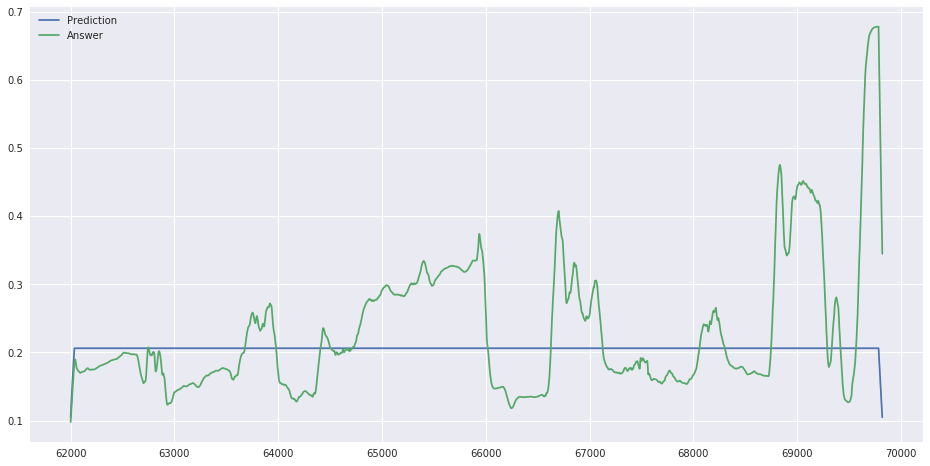

In [10]:
import seaborn as sns
bins = 80
norm_hist = True

sns.set()
plt.figure(figsize=(16, 8))
plt.plot(frames, conv_preds, label='Prediction')
plt.plot(answer_keys, conv_answer_vals, label='Answer')
plt.legend()